In [24]:
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import pprint
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools
import os
import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import f1_score
from functools import partial

In [2]:
data_dir = Path('/gpfs/data/geraslab/ekr6072/projects/study_indication/data')
data_path = data_dir / 'dataset.pkl'

In [3]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [4]:
from torch import nn

class ClinicalBERT(nn.Module):
  def __init__(self, num_classes):
      super(ClinicalBERT, self).__init__()
      self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
      self.linear = nn.Linear(768, num_classes)
      self.loss_func = nn.CrossEntropyLoss()
  
  def forward(self, **kwargs):
    x = self.bert(input_ids=kwargs['input_ids'], attention_mask=kwargs['attention_mask'])
    logits = self.linear(x['pooler_output'])
    label = kwargs['labels']
    loss = self.loss_func(logits, label)
    return {
      "loss": loss,
      "logits": logits
    }

In [5]:
with open(data_path, 'rb') as f:
  dataset = pickle.load(f)

In [6]:
def clean_dataset(dataset):
  output = {}
  for name, subset in dataset.items():
    clean_subset = []
    for data in subset:
      label = data['label']
      if label not in ['exclude', 'unknown']:
        clean_subset.append(data)
    output[name] = clean_subset
  return output

In [7]:
dataset = clean_dataset(dataset)

In [8]:
category2id = {
  '(high-risk) screening': 0,
  'extent of disease / pre-operative planning': 1,
  'additional workup': 2,
  '6-month follow-up / surveillance': 3,
  'treatment monitoring': 4,
  'exclude': 5,
  'unknown': 6,
}

In [9]:
train_texts = [data['text']['longText'] for data in dataset['train']]
train_labels = [category2id[data['label']] for data in dataset['train']]

In [10]:
val_texts = [data['text']['longText'] for data in dataset['val']]
val_labels = [category2id[data['label']] for data in dataset['val']]

In [11]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [12]:
lengths = []
for sequence in train_encodings['input_ids']:
  pad = np.where(np.array(sequence) == 0)[0]
  if len(pad) == 0:
    length = len(sequence)
  else: 
    length = pad.min()
  lengths.append(length)

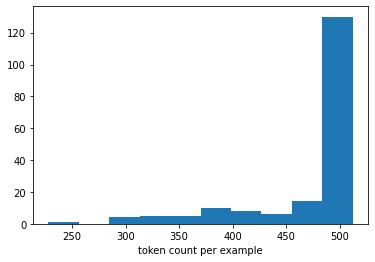

In [13]:
fig, ax = plt.subplots()
ax.hist(lengths, bins=10);
ax.set_xlabel('token count per example'); # add logits from all the classifiers and backprop through sum of the logits

In [14]:
import torch

class IndicationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IndicationDataset(train_encodings, train_labels)
val_dataset = IndicationDataset(val_encodings, val_labels)

In [15]:
from datasets import load_metric

metric = load_metric("accuracy")

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
train_dataloader = DataLoader(train_dataset, 16, shuffle=True)
val_dataloader = DataLoader(val_dataset, 16, shuffle=False)

In [18]:
def epoch_iter(num_epochs, dataloader):
    steps_per_epoch = len(dataloader)
    for epoch in range(num_epochs):
      for step in range(steps_per_epoch):
        yield epoch

In [21]:
@torch.no_grad()
def eval_loop(model, dataloader, device):
    """Run validation phase."""
    model.eval()

    # Keeping track of metrics
    total_loss = 0.0
    total_correct = 0.0
    total_count = 0
    all_labels = []
    all_preds = []

    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()}        
        outputs = model(**batch)
        loss = outputs["loss"]

        # Only count non-padding tokens
        # (Same idea as ignore_index=PAD_IDX above)
        preds = outputs['logits'].argmax(-1)
        labels = batch['labels']
        correct_preds = (labels == preds).sum()
        all_labels.append(labels)
        all_preds.append(preds)

        # Keeping track of metrics
        total_loss += loss.item()
        total_correct += correct_preds.item()
        total_count += preds.shape[0]
    all_labels = torch.cat(all_labels).cpu()
    all_preds = torch.cat(all_preds).cpu()
    return {
        "loss": total_loss / total_count,
        "accuracy": total_correct / total_count,
        "f1_score": f1_score(all_labels, all_preds, average='macro')
    }

def train_step(optimizer, model, batch):
    """Run a single train step."""
    model.train()
    optimizer.zero_grad()
    outputs = model(**batch)
    loss = outputs["loss"]
    loss.backward()
    optimizer.step()
    return loss.item()

In [108]:
def lr_lambda(current_step: int, warmup_steps: int, total_steps: int, decay_type='linear'):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    if decay_type is None:
        return 1.0
    elif decay_type == 'linear':
        w = - 1 / (total_steps - warmup_steps)
        return (current_step - warmup_steps) * w + 1.0
    elif decay_type == 'cosine':
        w = np.pi / (total_steps - warmup_steps)
        return 0.5 * np.cos(w * (current_step - warmup_steps)) + 0.5
    else:
        raise ValueError('invalid decay_type {} entered'.format(decay_type))

In [144]:
NUM_EPOCHS = 30
model = ClinicalBERT(5)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
warmup_steps = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timestamp = datetime.datetime.now()
date = timestamp.strftime("%Y%m%d")
time = timestamp.strftime("%H%M%S")
save_path = f'./results/{date}/{time}'
total_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = None if warmup_steps is None \
                    else torch.optim.lr_scheduler.LambdaLR(optimizer, partial(lr_lambda, warmup_steps=warmup_steps, 
                                                                                         total_steps=total_steps))
train_loss_list = []
writer = SummaryWriter(log_dir=os.path.join(save_path, 'tb_logs'))
model.to(device)
for step, epoch, batch in zip(range(total_steps), epoch_iter(NUM_EPOCHS, train_dataloader), itertools.cycle(train_dataloader)):
    batch = {key: value.to(device) for key, value in batch.items()}
    loss_val = train_step(
        optimizer=optimizer,
        model=model,
        batch=batch,
    )
    writer.add_scalar("learning_rate", optimizer.param_groups[0]['lr'], step)
    if lr_scheduler is not None:
        lr_scheduler.step()

    writer.add_scalar("epoch", epoch, step)
    writer.add_scalar("loss/train", loss_val, step)
    train_loss_list.append(loss_val)
    if step % 5 == 0 and step != 0:
        val_results = eval_loop(
            model=model,
            dataloader=val_dataloader,
            device=device
        )
        for key, value in val_results.items():
            writer.add_scalar(f"{key}/val", value, step)
        print("Step: {}/{}, val acc: {:.3f}, val f1: {:.3f}".format(
            step, 
            total_steps,
            val_results["accuracy"],
            val_results["f1_score"])
        )
writer.flush()
writer.close()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step: 5/360, val acc: 0.344, val f1: 0.142
Step: 10/360, val acc: 0.456, val f1: 0.125
Step: 15/360, val acc: 0.456, val f1: 0.125
Step: 20/360, val acc: 0.456, val f1: 0.125
Step: 25/360, val acc: 0.456, val f1: 0.125
Step: 30/360, val acc: 0.456, val f1: 0.125
Step: 35/360, val acc: 0.456, val f1: 0.125
Step: 40/360, val acc: 0.456, val f1: 0.125
Step: 45/360, val acc: 0.656, val f1: 0.312
Step: 50/360, val acc: 0.456, val f1: 0.125
Step: 55/360, val acc: 0.678, val f1: 0.320
Step: 60/360, val acc: 0.633, val f1: 0.303
Step: 65/360, val acc: 0.689, val f1: 0.321
Step: 70/360, val acc: 0.689, val f1: 0.317
Step: 75/360, val acc: 0.711, val f1: 0.330
Step: 80/360, val acc: 0.600, val f1: 0.412
Step: 85/360, val acc: 0.689, val f1: 0.401
Step: 90/360, val acc: 0.733, val f1: 0.465
Step: 95/360, val acc: 0.656, val f1: 0.490
Step: 100/360, val acc: 0.778, val f1: 0.516
Step: 105/360, val acc: 0.556, val f1: 0.311
Step: 110/360, val acc: 0.689, val f1: 0.506
Step: 115/360, val acc: 0.756,